# LangGraph : Multi-AgentWorkflows

대부분의 에이전트 런타임의 중요한 구성 요소인 *주기*(Cycle)를 포함하는 LLM 워크플로를 더 잘 생성할 수 있도록 하는 새로운 패키지([Python](https://pypi.org/project/langgraph/?ref=blog.langchain.dev) 및 [JS](https://www.npmjs.com/package/@langchain/langgraph?ref=blog.langchain.dev) 모두에서 사용 가능)인 [LangGraph](https://blog.langchain.dev/langgraph/)를 강조했습니다.  
출시의 일환으로 두 가지 간단한 런타임을 강조했는데, 하나는 `langchain`의 AgentExecutor와 동일한 것이고, 다른 하나는 메시지 전달 및 채팅 모델을 대상으로 하는 버전입니다.


오늘은 `langgraph` - 다중 에이전트 워크플로에 대한 두 번째 사용 사례를 설명한다.

- "다중 에이전트"는 무엇을 의미합니까?
- "다중 에이전트" 워크플로가 흥미로운 이유는 무엇인가요?
- 다중 에이전트 워크플로에 LangGraph를 사용하는 세 가지 구체적인 예
- 다중 에이전트 워크플로(GPT-Newspaper 및 CrewAI)를 사용하여 LangGraph를 기반으로 구축된 타사 애플리케이션의 두 가지 예
- 다른 프레임워크(Autogen 및 CrewAI)와의 비교

## "다중 에이전트"란 무엇입니까?

> "다중 에이전트"에 대해 이야기할 때, 우리는 특정 방식으로 연결된 언어 모델로 구동되는 여러 독립적인 행위자(actor)를 의미한다.

각 에이전트는 다른 에이전트와 가장 잘 협업할 수 있도록 (1)자체 프롬프트, (2)LLM, (3)도구 및 기타 사용자 지정 코드를 가질 수 있습니다.

서로 다른 다중 에이전트 워크플로에 대해 생각할 때 두 가지 주요 고려 사항이 있다.

1. 여러 독립 에이전트란 무엇인가?
2. 이러한 에이전트는 어떻게 연결되어 있는가?

이러한 생각은 `langgraph`에서 제공하는 것과 같은 그래프로 표현하는 것이 매우 적합합니다. 이 접근 방식에서 각 에이전트는 그래프의 노드이며 해당 연결은 가장자리로 표시됩니다. 제어 흐름은 가장자리에 의해 관리되며 그래프의 상태에 추가하여 통신합니다.

---

참고: 여기서 매우 관련된 개념은 *상태 기계(state machines*)의 개념인데, 우리는 이것을 인지 아키텍처(cognitive architectures)의 범주로 명시적으로 불렀습니다. 이러한 방식으로 볼 때 독립 에이전트 노드는 상태가 되고 이러한 에이전트가 연결되는 방식이 전이 행렬(transition matrices)입니다. [상태 머신은 레이블이 지정된 방향이 지정된 그래프로 볼 수 있기 때문에](https://www.cs.cornell.edu/courses/cs211/2006sp/Lectures/L26-MoreGraphs/state_mach.html?ref=blog.langchain.dev#:~:text=State%20machine%20as%20a%20graph,labeled%20with%20the%20corresponding%20events.) 이러한 것들을 같은 방식으로 생각할 것입니다.

[상태 머신](https://www.cs.cornell.edu/courses/cs211/2006sp/Lectures/L26-MoreGraphs/state_mach.html?ref=blog.langchain.dev#:~:text=State%20machine%20as%20a%20graph,labeled%20with%20the%20corresponding%20events.)은 컴퓨 터와 계산이 작동하는 방식에 대한 추상적인 사고방식입니다. 특히 외부의 이벤트에 응답해야 하는 사용자 인터페이스와 같은 반응형 시스템을 설명하는 데 유용합니다. 상태 머신에는 외부 이벤트에 응답하여 변경할 수 있는 내부 상태가 있습니다. 상태 머신이 외부 환경으로부터 이벤트를 수신하면 간단한 규칙에 따라 상태를 새 상태로 변경합니다. 또한 외부 환경에 중요한 동작을 수행할 수도 있습니다. 상태 머신의 클래식 버전에서 이 동작은 입력을 "수락"하는 것일 수 있습니다.

```plain
전이 행렬(transition matrices)"은 독립 에이전트 노드 간의 연결 방식, 즉 상태 간의 전이를 정의하는 방법을 나타냅니다.

독립 에이전트 노드: 시스템의 개별적인 상태를 나타냅니다. 각 노드는 특정 작업, 지식, 목표 등을 가질 수 있습니다.
상태 기계: 시스템이 시간이 지남에 따라 다양한 상태를 거치면서 작동하는 방식을 모델링하는 개념입니다.
전이: 한 상태에서 다른 상태로의 이동을 의미합니다.
전이 행렬: 이러한 전이의 확률 또는 가능성을 나타내는 수학적 구조입니다. 행렬의 각 요소는 특정 상태에서 다른 특정 상태로 이동할 확률을 나타냅니다.

문맥에서 전이 행렬은 독립 에이전트 노드 간의 연결 강도 또는 전이 가능성을 나타내는 도구로 사용됩니다. 이는 인지 아키텍처에서 상태 기계를 모델링하고 에이전트 간의 상호 작용을 정의하는 데 중요한 역할을 합니다. 각 상태에서 다음 상태로의 이동을 확률적으로 정의함으로써, 시스템의 행동을 예측하고 제어하는 데 도움이 됩니다.
```

---


## 다중 에이전트 설계의 이점

하나의 에이전트가 제대로 작동하지 않을 때 다중 에이전트가 유용한 이유

- 도구/책임을 그룹화하면 더 나은 결과를 얻을 수 있습니다. 에이전트는 수십 가지 도구 중에서 선택해야 하는 경우보다 집중된 작업에서 성공할 가능성이 더 높습니다.
- 별도의 프롬프트를 사용하면 더 나은 결과를 얻을 수 있습니다. 각 프롬프트에는 고유한 지침과 few-shot 예제가 있을 수 있습니다. 각 에이전트는 별도의 미세 조정된 LLM에 의해 구동될 수도 있습니다!
- 개발에 유용한 개념 모델입니다. 더 큰 애플리케이션을 중단하지 않고 각 에이전트를 개별적으로 평가하고 개선할 수 있습니다.

멀티 에이전트 디자인을 사용하면 복잡한 문제를 전문 에이전트와 LLM 프로그램의 대상으로 할 수 있는 다루기 쉬운 작업 단위로 나눌 수 있습니다.

## 다중 에이전트 예제

다중 에이전트 워크플로의 세 가지 개별 예제를 `langgraph` 리포지토리에 추가했습니다. 이들 각각은 위의 두 가지 질문에 대해 약간 다른 답변을 가지고 있으며, 예를 강조할 때 살펴보겠습니다. 이 세 가지 예시는 저희가 강조할 수 있는 예시 중 일부에 불과하다는 점을 유의하는 것이 중요합니다 - 거의 확실하게 다른 예시가 있으며 커뮤니티에서 어떤 결과가 나올지 기대하고 있습니다!

### 다중 에이전트 협업

**코드 링크** :

- [파이썬](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/agent_supervisor.ipynb?ref=blog.langchain.dev)
- [파이썬_한글](./agent_supervisor_ko.ipynb)
- [JS (제이에스)](https://github.com/langchain-ai/langgraphjs/blob/main/examples/multi_agent/multi-agent-collaboration.ipynb?ref=blog.langchain.dev)


이 예제에서는 서로 다른 에이전트가 메시지의 **공유** 스크래치패드에서 협업합니다. 이것은 둘 중 하나가 수행하는 모든 작업이 다른 사람에게 표시됨을 의미합니다. 이렇게 하면 다른 상담원이 완료된 모든 개별 단계를 볼 수 있다는 이점이 있습니다. 이것은 때때로 이 모든 정보를 전달하는 것이 지나치게 장황하고 불필요하며 때로는 에이전트의 최종 답변만 필요하다는 단점이 있습니다. 우리는 이 **협업**을 스크래치패드라고 부릅니다.

**여러 독립 에이전트란 무엇입니까?**

이 경우, 독립 에이전트는 실제로 단일 LLM 호출일 뿐입니다. 구체적으로 말하자면, 특정 프롬프트 템플릿(특정 시스템 메시지를 사용하여 특정 방식으로 입력을 형식화하기 위해)과 LLM 호출입니다.

**이러한 에이전트는 어떻게 연결되어 있습니까?**

다음은 이러한 에이전트가 연결되는 방식을 시각화한 것입니다.

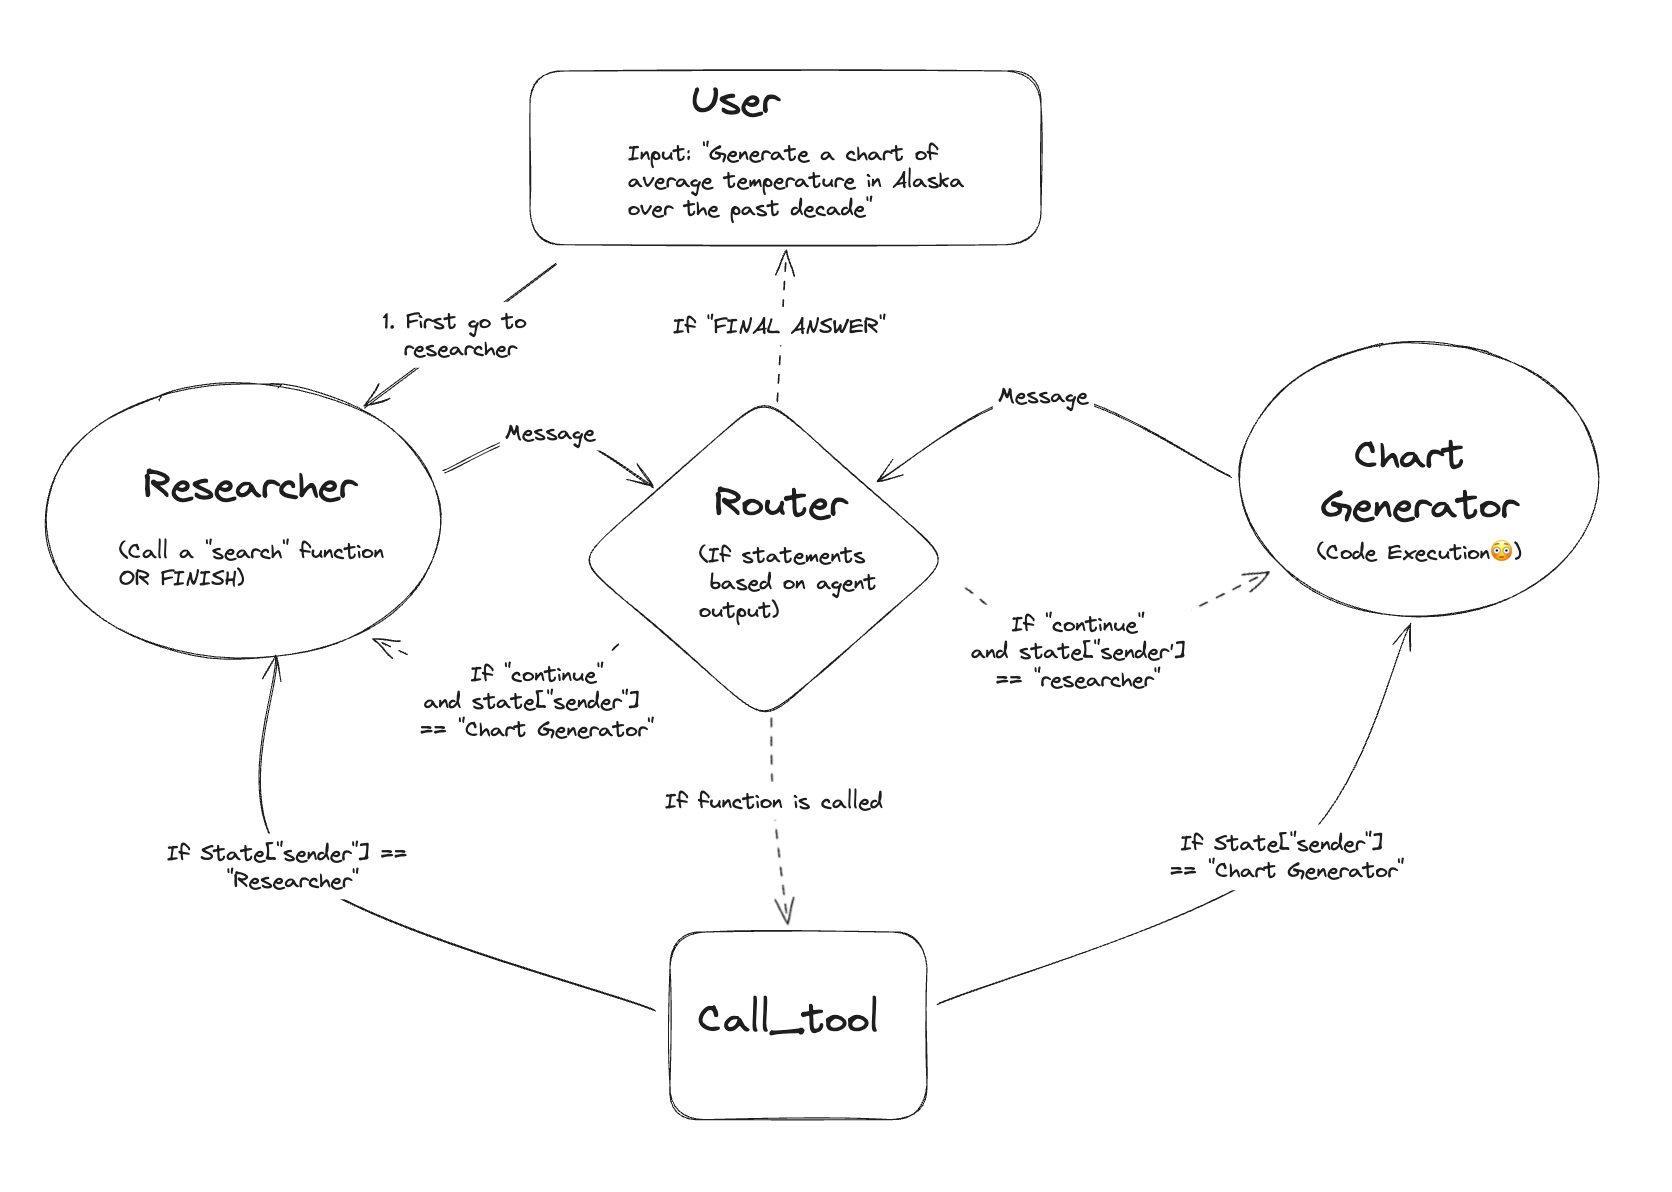

상태 전환을 제어하는 주요 것은 *라우터*이지만 규칙 기반 라우터이므로 매우 간단합니다. 기본적으로 각 LLM 호출 후에 출력을 확인합니다. 도구가 호출되면 해당 도구를 호출합니다. 도구가 호출되지 않고 LLM이 "FINAL ANSWER"라고 응답하면 사용자에게 돌아갑니다. 그렇지 않으면 (도구가 호출되지 않고 LLM이 "FINAL ANSWER"에 응답하지 않으면 다른 LLM으로 이동합니다.

### 상담원 수퍼바이저

**예제:**

- [파이썬](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/agent_supervisor.ipynb?ref=blog.langchain.dev)
- [파이썬_한글](./agent_supervisor_ko.ipynb)
- [JS (제이에스)](https://github.com/langchain-ai/langgraphjs/blob/main/examples/multi_agent/agent_supervisor.ipynb?ref=blog.langchain.dev)

이 예제에서는 여러 에이전트가 연결되어 있지만 위와 비교하여 공유 스크래치 패드를 공유하지 않습니다. 오히려, 그들은 자신의 독립적 인 스크래치 패드를 가지고 있으며, 최종 응답은 전역 스크래치 패드에 추가됩니다.

**여러 독립 에이전트란 무엇입니까?**

이 경우 독립 에이전트는 LangChain 에이전트입니다. 이는 그들이 그들 자신의 개별 프롬프트, LLM 및 도구를 가지고 있다는 것을 의미합니다. 호출될 때는 단일 LLM 호출이 아니라 AgentExecutor 의 실행입니다.

**이러한 에이전트는 어떻게 연결되어 있습니까?**

**상담원 수퍼바이**저는 개별 상담원에게 라우팅하는 일을 담당합니다.

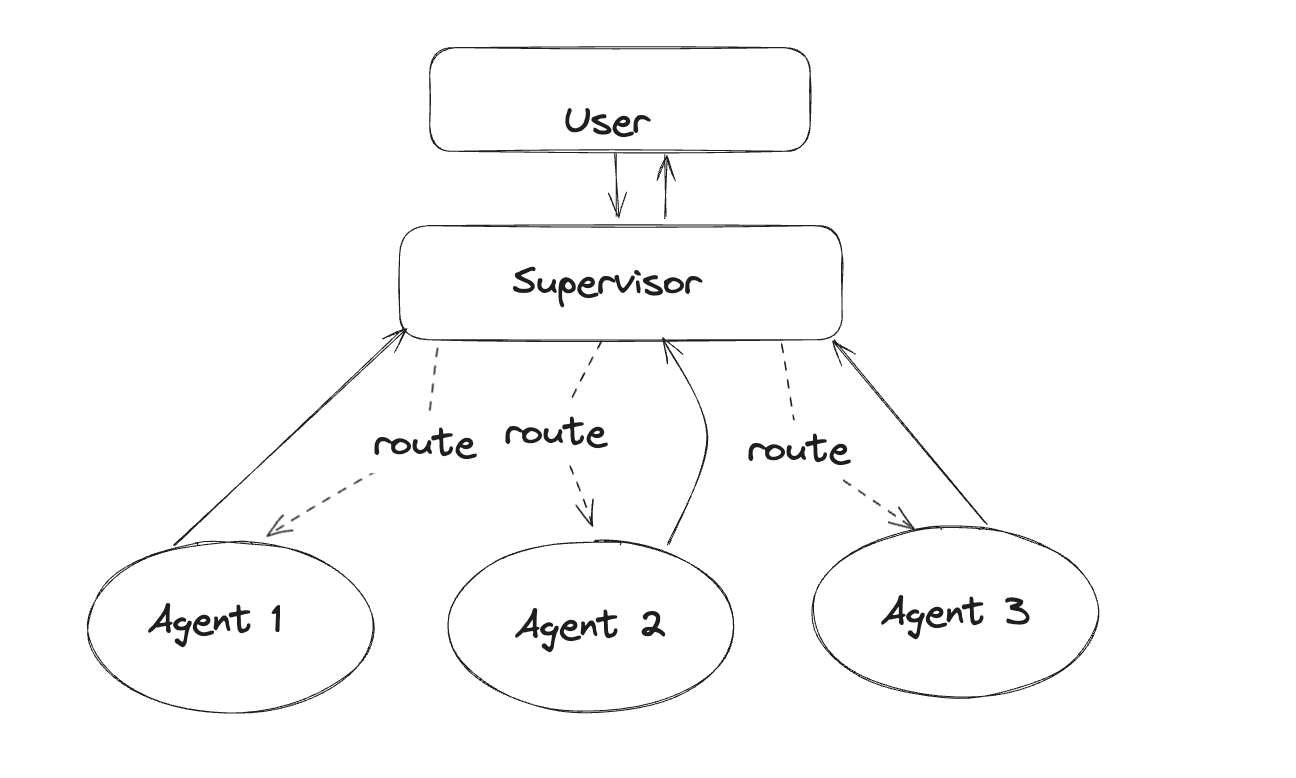

이런 식으로, 수퍼바이저는 도구가 다른 에이전트인 에이전트로 생각할 수도 있습니다!

### 계층적 에이전트 팀

**예제:**

- [파이썬](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb?ref=blog.langchain.dev)
- [JS (제이에스)](https://github.com/langchain-ai/langgraphjs/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb?ref=blog.langchain.dev)

이것은 위의 예제와 유사하지만 이제 노드의 에이전트는 실제로 다른 개체 자체입니다. 이는 LangChain AgentExecutor를 에이전트 런타임으로 사용하는 것보다 훨씬 더 많은 유연성을 제공합니다. 우리는 이것을 *계층적 팀*이라고 부르는데, 그 이유는 하위 에이전트가 어떤 면에서 팀으로 간주될 수 있기 때문입니다.`langgraph`

**여러 독립 에이전트란 무엇입니까?**

이들은 이제 다른 에이전트입니다.`langgraph`

**이러한 에이전트는 어떻게 연결되어 있습니까?**

수퍼바이저 에이전트가 이를 연결합니다.

!https://blog.langchain.dev/content/images/2024/01/hierarchical-diagram.png

## YouTube 둘러보기

이 세 가지 예를 안내하기 위해 YouTube 동영상을 추가했습니다. 이 복잡한 주제를 좀 더 쉽게 이해하는 데 도움이 되기를 바랍니다!

## 제3자 응용 프로그램

이번 출시의 일환으로, 다중 에이전트의 개념을 활용하는 LangGraph를 기반으로 구축된 몇 가지 애플리케이션을 집중 조명하게 되어 기쁩니다.

### [GPT-신문](https://github.com/assafelovic/gpt-newspaper?ref=blog.langchain.dev)

[이것은 GPT-Researcher](https://github.com/assafelovic/gpt-researcher?ref=blog.langchain.dev)의 마음에 의한 새로운 프로젝트입니다. GPT-Newspaper은 사용자 선호도에 맞는 맞춤형 신문을 제작하도록 설계된 혁신적인 자율 에이전트입니다. GPT Newspaper은 AI의 힘을 활용하여 개인의 취향과 관심사에 따라 콘텐츠를 선별, 작성, 디자인 및 편집함으로써 우리가 뉴스를 소비하는 방식에 혁명을 일으킵니다. 아키텍처는 6개의 특수 하위 에이전트로 구성됩니다. 한 가지 핵심 단계가 있습니다 - 작성자는 비평 루프를 <>하여 유용한 사이클을 추가합니다.

!https://blog.langchain.dev/content/images/2024/01/68747470733a2f2f746176696c792d6d656469612e73332e616d617a6f6e6177732e636f6d2f6770742d6e65777370617065722d6172636869746563747572652e706e67.png

### [승무원 AI 예시](https://github.com/joaomdmoura/crewAI-examples/tree/main/CrewAI-LangGraph?ref=blog.langchain.dev)

주앙 모라(Joao Moura)는 [CrewAI](https://github.com/joaomdmoura/crewai?ref=blog.langchain.dev)를 LangChain 및 LangGraph와 함께 사용하여 자동으로 이메일을 확인하고 초안을 작성하는 프로세스를 자동화하는 좋은 예를 들었습니다. CrewAI는 자율 AI 에이전트를 오케스트레이션하여 복잡한 작업을 효율적으로 협업하고 실행할 수 있도록 합니다.

이 예제의 그래프는 다음과 같습니다.

!https://blog.langchain.dev/content/images/2024/01/CrewAI-LangGraph.png

그는 또한 이것을 실제로 보여주는 환상적인 YouTube 비디오를 작업했습니다.

## 다른 프레임워크

LangGraph는 다중 에이전트 워크플로를 지원하는 첫 번째 프레임워크가 아닙니다. 이러한 프레임워크 간의 대부분의 차이점은 주로 그들이 도입하는 멘탈 모델과 개념에 있습니다.

### [오토젠](https://github.com/microsoft/autogen?ref=blog.langchain.dev)

Autogen은 아마도 최초의 다중 에이전트 프레임워크로 부상했을 것입니다. LangGraph와 Autogen의 멘탈 모델에서 가장 큰 차이점은 에이전트 구성에 있습니다. LangGraph는 서로 다른 에이전트와 전이 확률을 명시적으로 정의하는 접근 방식을 선호하며, 이를 그래프로 표현하는 것을 선호합니다. Autogen은 이를 "대화"로 표현합니다. 우리는 이 "그래프" 프레이밍을 더 직관적으로 만들고 노드 간의 전환 확률을 실제로 제어하려는 더 복잡하고 독단적인 워크플로를 구성하는 데 더 나은 개발자 경험을 제공한다고 믿습니다. 또한 "대화"에 명시적으로 캡처*되지 않는 워크플로를* 지원합니다.

Autogen과 LangGraph의 또 다른 주요 차이점은 LangGraph가 LangChain 생태계에 완전히 통합되어 모든 LangChain 통합 및 LangSmith 관찰 가능성을 최대한 활용할 수 있다는 것입니다.

### [크루AI](https://github.com/joaomdmoura/crewAI?ref=blog.langchain.dev)

강조하고 싶은 또 다른 핵심 프레임워크는 CrewAI입니다. CrewAI는 최근 다중 에이전트 "팀"을 만드는 인기 있는 방법으로 부상했습니다. LangGraph와 비교할 때 CrewAI는 더 높은 수준의 프레임워크인 반면 LangGraph는 에이전트에 대한 훨씬 더 낮은 수준의 제어 기능을 제공합니다.